# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline for U-Net using ultrasound data.  

In [10]:
# run this cell only in Google Colab
COLAB = False
if COLAB:
    # === 1. Clone your repo ===
    !git clone https://github.com/jacobinsilico/ReconstructUS.git
    %cd ReconstructUS

    # === 2. Install required packages ===
    !pip install piq torchinfo pytorch-msssim

    # === 3. Add repo to Python path ===
    import sys
    sys.path.append('/content/ReconstructUS')

    # === 4. Mount Google Drive ===
    from google.colab import drive
    drive.mount('/content/drive')

In [11]:
# === Standard Library ===
import os
import random
from glob import glob

# === Scientific & ML ===
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# === PyTorch ===
import torch
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch.nn.functional as F

# === Progress & Splitting ===
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

# === Models ===
from models.unet     import CustomUNet          # 1M40K params 24 base channels
from models.effunet  import CustomEfficientUNet # 970K params  16 channels

# === Data Handling ===
from dataloader.load_rf     import load_rf_stack, group_plane_waves, compute_global_min_max
from dataloader.load_gt     import load_gt_stack
from dataloader.norm_sample import normalize_to_01

# === Utils ===
from utils.visualize_raw import visualize_gt_db, visualize_rf_line
from utils.losses        import ssim_loss, ms_ssim_loss, mae_loss, fft_loss, edge_loss, CharbonnierLoss

from utils.metrics       import compute_metrics
from utils.augment       import add_speckle_noise, add_jitter_and_noise, zero_out_rf_channels

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ms_ssim

## Configuration
Define all the training parameters in one variable.

In [12]:
TARGET_DEPTH = 1600 # target number of samples for all considered RF files
DATASET_SIZE = 300  # number of total samples loaded in the notebook
BATCH_SIZE = 16
PW_PER_IMG = 1 # number of plane waves we want to use to reconstruct one GT image
DOWNSAMPLE_FACTOR = 2 # we want to downsample our image to make it easier for smaller model to reconstruct

In [13]:
CONFIG = {
    'model_name': 'effunet',              # options: 'unet', 'effunet'
    'loss_function': 'combined',          # options: 'ssim', 'mae', 'combined' TODO: make it more customizable
    'batch_size': BATCH_SIZE,
    'lr': 5e-3,
    'epochs': 200,
    'input_size': None,                   # set later based on loaded .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # === Data paths ===
    'data_dir_rf': '/content/drive/MyDrive/SoCDAML-Project/data/raw',
    'data_dir_img': '/content/drive/MyDrive/SoCDAML-Project/data/processed',

    # === Checkpoint path ===
    'checkpoints_dir': None,         # set below
}

# Set checkpoint save directory inside project folder
if not COLAB:
    CONFIG['data_dir_rf'] = os.path.join('data', 'raw')
    CONFIG['data_dir_img'] = os.path.join('data', 'processed')
    CONFIG['checkpoints_dir'] = os.path.join('..', 'checkpoints', CONFIG['model_name'])
    os.makedirs(CONFIG['checkpoints_dir'], exist_ok=True)

if COLAB:
    CONFIG['checkpoints_dir'] = os.path.join('/content/drive/MyDrive/SoCDAML-Project/checkpoints', CONFIG['model_name'])
    os.makedirs(CONFIG['checkpoints_dir'], exist_ok=True)

In [14]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA is available! Using GPU: {device_name}")
else:
    print("❌ CUDA is not available. Training will be **very slow** on CPU.")

❌ CUDA is not available. Training will be **very slow** on CPU.


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

Computing global min/max...


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Loading and normalizing RF frames...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


RF tensor final shape: torch.Size([450, 1600, 128])
Value range:  -1.0 1.0


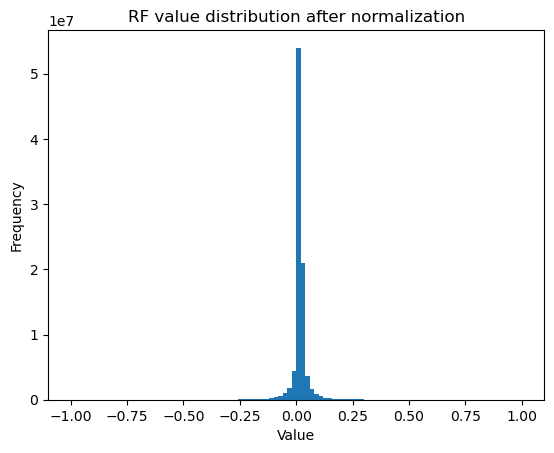

In [15]:
# CORRECT DONT TOUCH
# Gather paths
rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))

# First pass: compute normalization stats
global_min, global_max = compute_global_min_max(rf_paths)

# Second pass: load RF, normalize, pad
rf_tensor = load_rf_stack(rf_paths, TARGET_DEPTH, global_min, global_max)

# Optional: group plane waves if using multiple per image
if PW_PER_IMG != 1:
    rf_tensor = group_plane_waves(rf_tensor, PW_PER_IMG)

# -------------------------------
# 4. Sanity Checks
# -------------------------------
print("RF tensor final shape:", rf_tensor.shape)
print("Value range: ", rf_tensor.min().item(), rf_tensor.max().item())
assert -1.01 <= rf_tensor.min() <= 0.0, "RF min value out of range!"
assert  0.0 <= rf_tensor.max() <= 1.01, "RF max value out of range!"

# Optional histogram to visualize value distribution
plt.hist(rf_tensor.flatten().numpy(), bins=100)
plt.title("RF value distribution after normalization")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

[INFO] Global max (linear magnitude): 907.6446


100%|██████████| 6/6 [00:00<00:00, 86.13it/s]

We are using 1 waves per reconstructed image!
GT tensor shape: torch.Size([450, 192, 304])


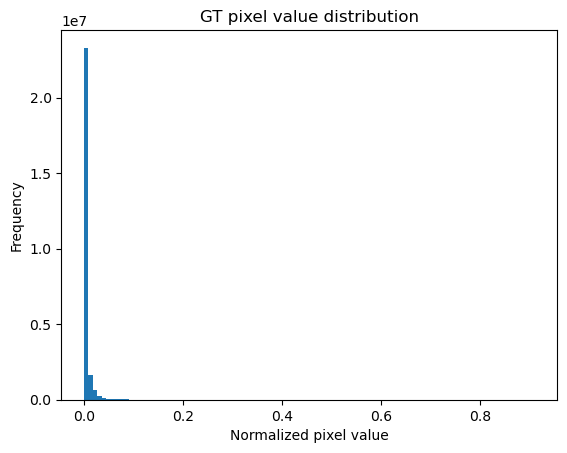

In [16]:
# CORRECT DONT TOUCH
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))
gt_tensor = load_gt_stack(img_paths, repeats_per_img=75//PW_PER_IMG, downsample_factor=DOWNSAMPLE_FACTOR)  # Output: [N x 192 x 304]

# Sanity check
print(f"We are using {PW_PER_IMG} waves per reconstructed image!")
print("GT tensor shape:", gt_tensor.shape)   # Output: [N x 192 x 304] -> We are working on images downsampled TWICE

assert 0.0 <= gt_tensor.min() <= 1.0 
assert 0.0 <= gt_tensor.max() <= 1.0

# Histogram 
plt.hist(gt_tensor.flatten().numpy(), bins=100)
plt.title("GT pixel value distribution")
plt.xlabel("Normalized pixel value")
plt.ylabel("Frequency")
plt.show()

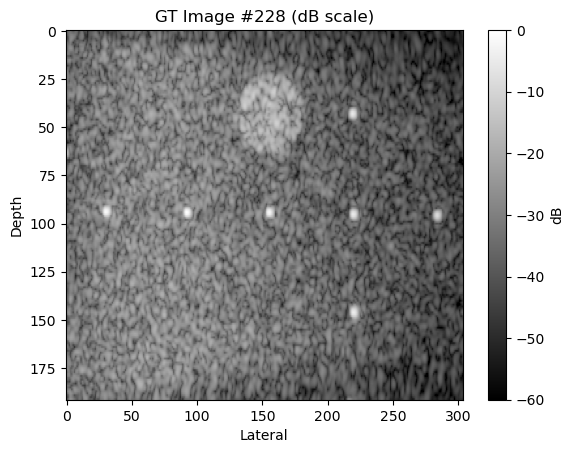

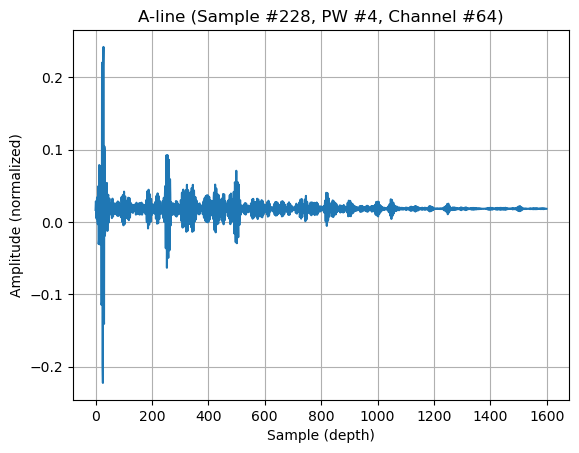

In [17]:
# visualize random image from the ones read WORKS FOR BOTH 3D and 4D RF data
random_index = random.randint(0, gt_tensor.shape[0] - 1)

visualize_gt_db(gt_tensor, idx=random_index)
visualize_rf_line(rf_tensor, file_idx=random_index, pw_idx=4, ch_idx=64)

## Data Augmentation
In this part we create new tensors with augmented GT images and zeroes out transducer channels. Output of this section should be DataLoader.

In [18]:
# First split: 80% train, 20% temp (val + test)
rf_train, rf_temp, gt_train, gt_temp = train_test_split(rf_tensor, gt_tensor, test_size=0.5, random_state=42, shuffle=True)

# Second split: 50% val, 50% test from the remaining 20%
rf_val, rf_test, gt_val, gt_test = train_test_split(rf_temp, gt_temp, test_size=0.5, random_state=42, shuffle=True)

Original shape: torch.Size([225, 192, 304])
Augmented shape: torch.Size([225, 192, 304])
Visualizing index: 201


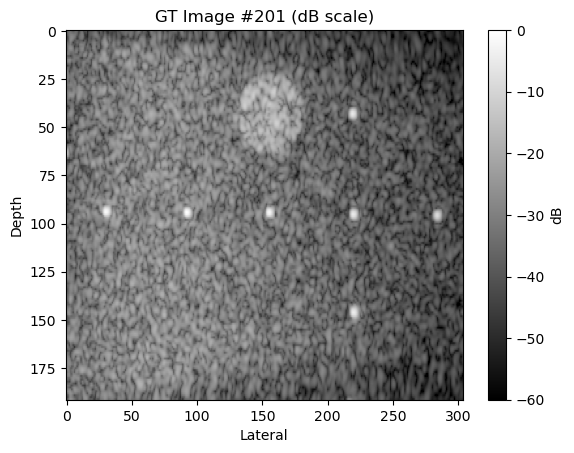

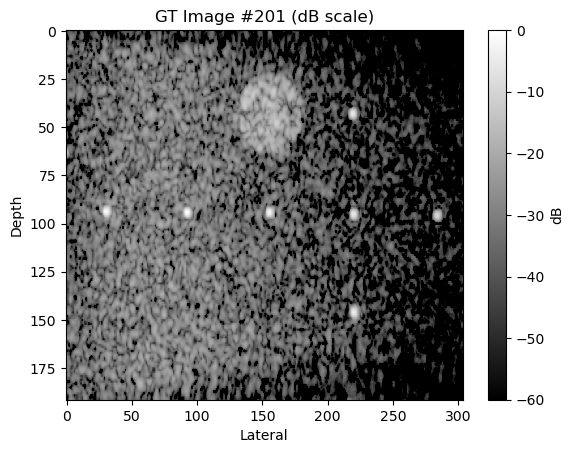

In [19]:
# ==== Test it on gt_train ====
gt_augmented = add_jitter_and_noise(gt_train)

print("Original shape:", gt_train.shape)
print("Augmented shape:", gt_augmented.shape)

# Visual check with a random index
idx_test1 = torch.randint(0, gt_train.shape[0], (1,)).item()
print(f"Visualizing index: {idx_test1}")

visualize_gt_db(gt_train, idx=idx_test1)
visualize_gt_db(gt_augmented, idx=idx_test1)

RF original shape:  torch.Size([225, 1600, 128])
RF augmented shape: torch.Size([225, 1600, 128])
Dropped channel indices: [38, 15, 78, 101, 115, 42, 92, 37, 25, 75, 72, 61]
Visualizing file index: 175, PW: 4, Channel: 38
Original RF slice:


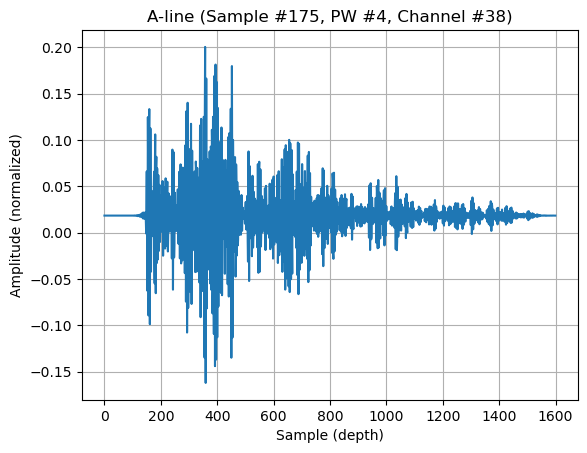

Augmented RF slice:


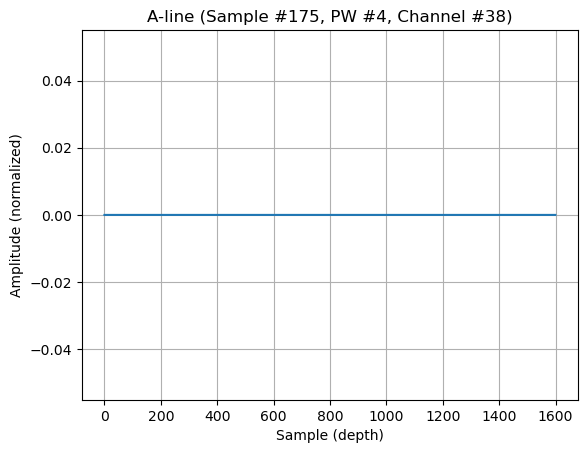

In [20]:
# ==== Test it on rf_train ====
rf_augmented, zeroed_idx = zero_out_rf_channels(rf_train, dropout_rate=0.1)

print("RF original shape: ", rf_train.shape)
print("RF augmented shape:", rf_augmented.shape)
print("Dropped channel indices:", zeroed_idx)

# Choose a random sample index from rf_train
file_idx = torch.randint(0, rf_train.shape[0], (1,)).item()
pw_idx = 4 # can be max 4 if we use 5 plane waves
ch_idx = zeroed_idx[0]

print(f"Visualizing file index: {file_idx}, PW: {pw_idx}, Channel: {ch_idx}")

# Visualize original
print("Original RF slice:")
visualize_rf_line(rf_train, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)

# Visualize zeroed
print("Augmented RF slice:")
visualize_rf_line(rf_augmented, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)

In [21]:
# print shapes of tensors
print("RF train shape:", rf_train.shape)
print("GT train shape:", gt_train.shape)
print("RF val shape:", rf_val.shape)
print("GT val shape:", gt_val.shape)
print("RF test shape:", rf_test.shape)
print("GT test shape:", gt_test.shape)

RF train shape: torch.Size([225, 1600, 128])
GT train shape: torch.Size([225, 192, 304])
RF val shape: torch.Size([112, 1600, 128])
GT val shape: torch.Size([112, 192, 304])
RF test shape: torch.Size([113, 1600, 128])
GT test shape: torch.Size([113, 192, 304])


## Data Augmentation
This is a short section where I augment the data to artificially increase the dataset size.

In [22]:
# === Augmentation settings for realistic diversity ===
augmentation_presets = [
    {'contrast': 1.002,  'noise': 0.0004, 'dropout': 0.10},
    {'contrast': 0.998,  'noise': 0.0005, 'dropout': 0.15},
    {'contrast': 1.0005, 'noise': 0.0006, 'dropout': 0.20},
    {'contrast': 1.001,  'noise': 0.0003, 'dropout': 0.05},
    {'contrast': 0.999,  'noise': 0.0005, 'dropout': 0.10}
]

NUM_AUGMENTED_SETS = len(augmentation_presets)

In [23]:
# === Augment GT and RF data ===
gt_augmented_list = []
rf_augmented_list = []

for i, preset in enumerate(augmentation_presets):
    # Apply GT jitter & noise
    gt_aug = add_jitter_and_noise(
        gt_tensor=gt_train,
        contrast_factor=preset['contrast'],
        noise_std=preset['noise'],
        prob=1.0
    )

    # Zero out random RF channels
    rf_aug, dropped = zero_out_rf_channels(
        rf_tensor=rf_train,
        dropout_rate=preset['dropout']
    )

    gt_augmented_list.append(gt_aug.unsqueeze(1))        # [N, 1, H, W]
    rf_augmented_list.append(rf_aug.unsqueeze(1))        # [N, 1, D, C]

    print(f"[AUG {i+1}] Contrast={preset['contrast']}, Noise={preset['noise']}, Dropout={preset['dropout']} | Dropped={dropped}")
    print(f"         RF shape: {rf_aug.shape}, GT shape: {gt_aug.shape}\n")

[AUG 1] Contrast=1.002, Noise=0.0004, Dropout=0.1 | Dropped=[106, 102, 45, 104, 34, 47, 68, 83, 90, 109, 62, 18]
         RF shape: torch.Size([225, 1600, 128]), GT shape: torch.Size([225, 192, 304])

[AUG 2] Contrast=0.998, Noise=0.0005, Dropout=0.15 | Dropped=[25, 90, 28, 31, 109, 113, 118, 11, 45, 120, 66, 40, 5, 126, 93, 86, 127, 47, 9]
         RF shape: torch.Size([225, 1600, 128]), GT shape: torch.Size([225, 192, 304])

[AUG 3] Contrast=1.0005, Noise=0.0006, Dropout=0.2 | Dropped=[115, 122, 63, 33, 16, 81, 76, 41, 11, 54, 99, 74, 118, 60, 18, 119, 23, 102, 64, 55, 114, 104, 35, 14, 9]
         RF shape: torch.Size([225, 1600, 128]), GT shape: torch.Size([225, 192, 304])

[AUG 4] Contrast=1.001, Noise=0.0003, Dropout=0.05 | Dropped=[127, 10, 34, 1, 19, 81]
         RF shape: torch.Size([225, 1600, 128]), GT shape: torch.Size([225, 192, 304])

[AUG 5] Contrast=0.999, Noise=0.0005, Dropout=0.1 | Dropped=[91, 3, 102, 82, 17, 120, 50, 109, 16, 116, 65, 6]
         RF shape: torch.Siz


[AUG 1] — Showing two random GT samples:
 - Sample indices: 120, 48


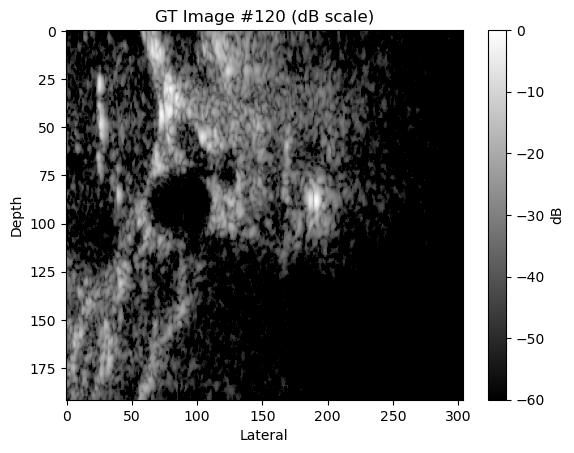

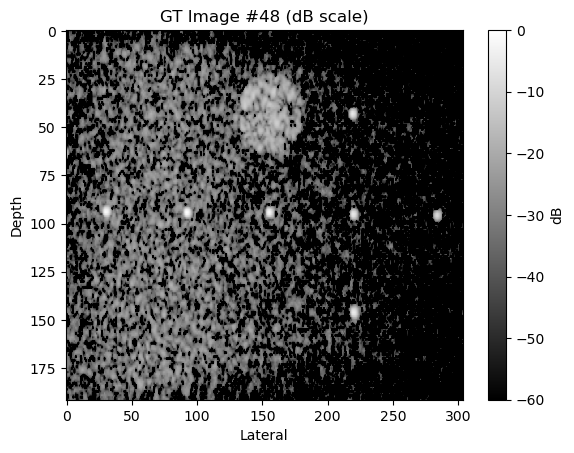


[AUG 2] — Showing two random GT samples:
 - Sample indices: 52, 90


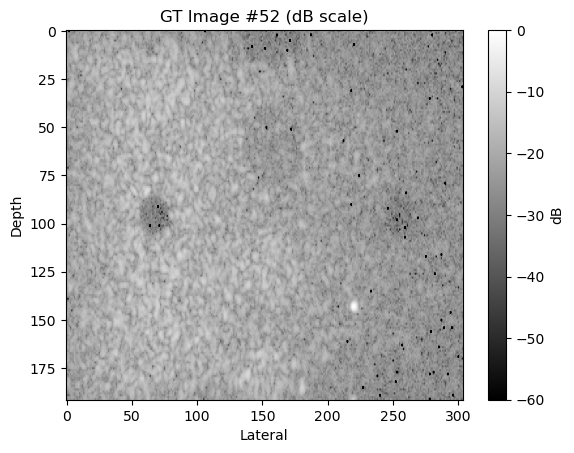

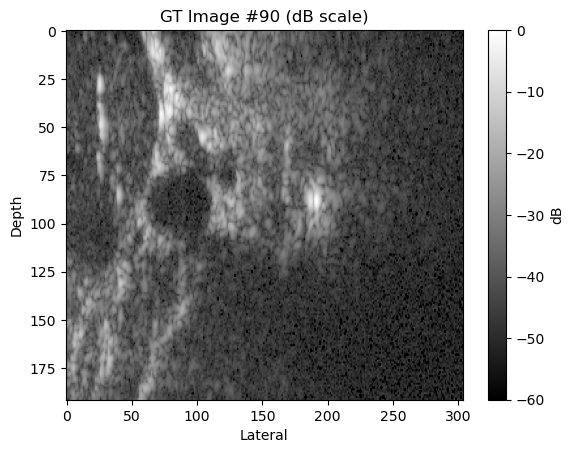


[AUG 3] — Showing two random GT samples:
 - Sample indices: 204, 53


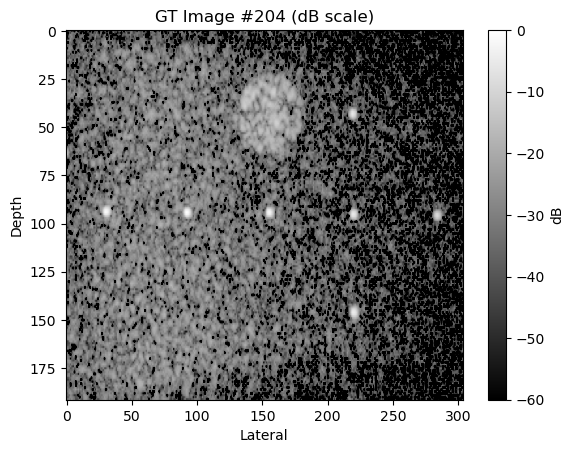

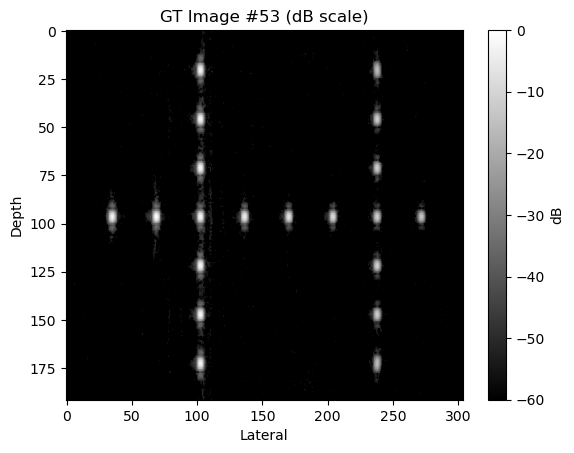


[AUG 4] — Showing two random GT samples:
 - Sample indices: 163, 127


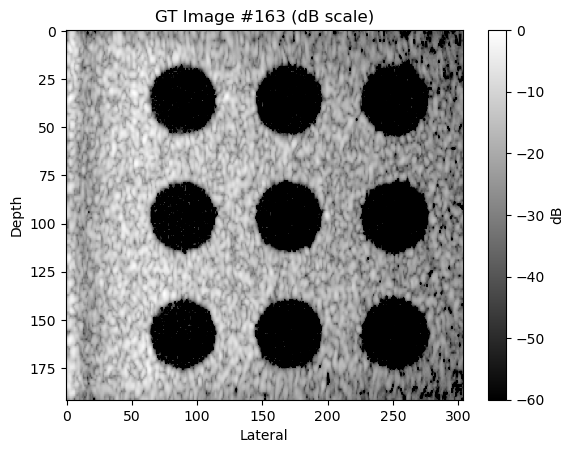

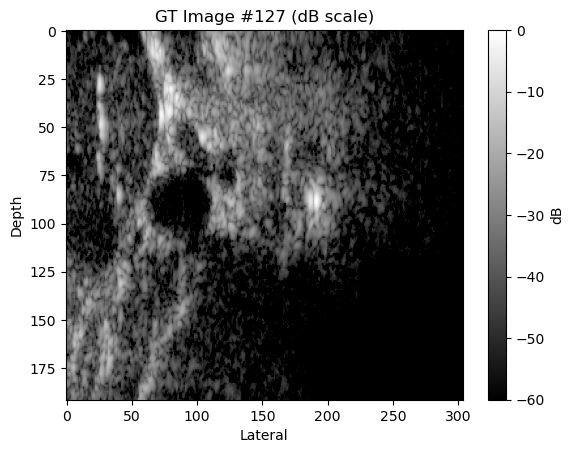


[AUG 5] — Showing two random GT samples:
 - Sample indices: 129, 182


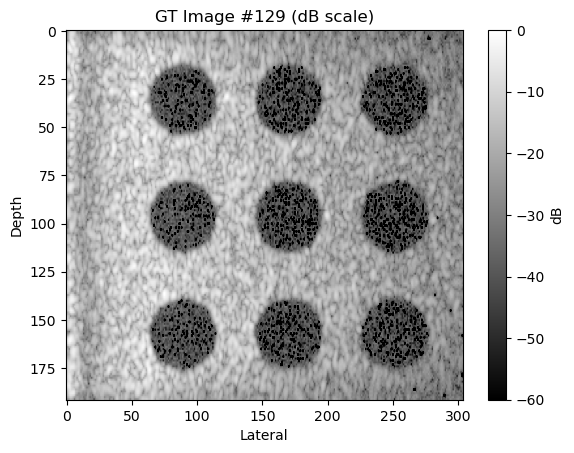

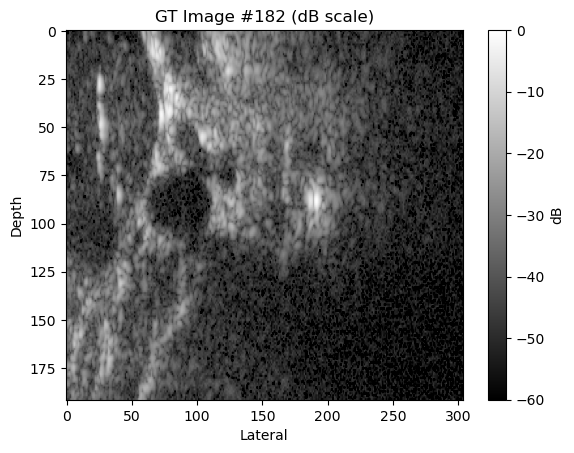

In [24]:
# === Sanity Check: Visualize 2 random GT images from each augmentation ===
for i, gt_aug in enumerate(gt_augmented_list):
    print(f"\n[AUG {i+1}] — Showing two random GT samples:")
    
    # Pick 2 random indices
    idx1, idx2 = random.sample(range(gt_aug.shape[0]), 2)

    print(f" - Sample indices: {idx1}, {idx2}")
    
    # Plot both
    visualize_gt_db(gt_aug.squeeze(1), idx1)
    visualize_gt_db(gt_aug.squeeze(1), idx2)

In [25]:
# === Create training datasets from augmented pairs ===
train_datasets = [
    TensorDataset(rf_augmented_list[i], gt_augmented_list[i])
    for i in range(NUM_AUGMENTED_SETS)
]

# Merge into a single large training dataset
train_full_ds = ConcatDataset(train_datasets)

# Validation and test sets (no augmentation)
val_ds  = TensorDataset(rf_val.unsqueeze(1), gt_val.unsqueeze(1))
test_ds = TensorDataset(rf_test.unsqueeze(1), gt_test.unsqueeze(1))


In [26]:
# === Sanity check ===
print("Final dataset sizes:")
for i, ds in enumerate(train_datasets):
    print(f" - Augmented set {i+1}: {len(ds)} samples")
print(f" - Combined train set: {len(train_full_ds)} samples")
print(f" - Validation set: {len(val_ds)} samples")
print(f" - Test set: {len(test_ds)} samples")


Final dataset sizes:
 - Augmented set 1: 225 samples
 - Augmented set 2: 225 samples
 - Augmented set 3: 225 samples
 - Augmented set 4: 225 samples
 - Augmented set 5: 225 samples
 - Combined train set: 1125 samples
 - Validation set: 112 samples
 - Test set: 113 samples


In [27]:
train_combined = ConcatDataset(train_datasets)

train_loader = DataLoader(train_combined, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)

# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")

Train RF shape: torch.Size([16, 1, 1600, 128]), GT shape: torch.Size([16, 1, 192, 304])
Val RF shape: torch.Size([16, 1, 1600, 128]), GT shape: torch.Size([16, 1, 192, 304])
Test RF shape: torch.Size([16, 1, 1600, 128]), GT shape: torch.Size([16, 1, 192, 304])


## Model Architecture
Here we define the model architecture used for training.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary 

# This model contains 970,202 trainable params and was the second one developed in the project
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1,
                                   groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.act(x)


class ResidualSeparableBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck_ratio=2, use_dropout=False, p=0.1):
        super().__init__()
        mid_channels = out_channels // bottleneck_ratio
        self.use_projection = in_channels != out_channels

        self.conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, mid_channels),
            DepthwiseSeparableConv(mid_channels, out_channels)
        )

        self.dropout = nn.Dropout2d(p=p) if use_dropout else nn.Identity()
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1) if self.use_projection else nn.Identity()

    def forward(self, x):
        residual = self.proj(x)
        x = self.conv(x)
        x = self.dropout(x)
        return x + residual


class CustomEfficientUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=16):
        super().__init__()

        # Encoder
        self.enc1 = ResidualSeparableBottleneckBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResidualSeparableBottleneckBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ResidualSeparableBottleneckBlock(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ResidualSeparableBottleneckBlock(base_channels * 4, base_channels * 8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels * 8, base_channels * 16, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 16),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(base_channels * 16, base_channels * 16, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 16),
            nn.LeakyReLU(0.1, inplace=True)
        )

        # Decoder
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels * 16, base_channels * 4, kernel_size=1)
        )
        self.dec4 = ResidualSeparableBottleneckBlock(base_channels * 4 + base_channels * 8, base_channels * 4)

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels * 4, base_channels * 2, kernel_size=1)
        )
        self.dec3 = ResidualSeparableBottleneckBlock(base_channels * 2 + base_channels * 4, base_channels * 2)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels * 2, base_channels, kernel_size=1)
        )
        self.dec2 = ResidualSeparableBottleneckBlock(base_channels + base_channels * 2, base_channels)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_channels, base_channels, kernel_size=1)
        )
        self.dec1 = ResidualSeparableBottleneckBlock(base_channels + base_channels, base_channels)

        self.sharpen = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.final = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        x_b = self.bottleneck(self.pool4(x4))

        d4 = self.dec4(torch.cat([self.up4(x_b), x4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), x3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), x2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), x1], dim=1))

        out = self.sharpen(d1)
        out = self.final(out)
        return out

In [36]:
model = CustomEfficientUNet(in_channels=1, base_channels=16)
model.eval()

x = torch.randn(1, 1, 1600, 128)
y = model(x)
summary(model, input_size=(1, 1, 1600, 128))

Layer (type:depth-idx)                        Output Shape              Param #
CustomEfficientUNet                           [1, 1, 1600, 128]         --
├─ResidualSeparableBottleneckBlock: 1-1       [1, 16, 1600, 128]        --
│    └─Conv2d: 2-1                            [1, 16, 1600, 128]        32
│    └─Sequential: 2-2                        [1, 16, 1600, 128]        --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 8, 1600, 128]         33
│    │    └─DepthwiseSeparableConv: 3-2       [1, 16, 1600, 128]        232
│    └─Identity: 2-3                          [1, 16, 1600, 128]        --
├─MaxPool2d: 1-2                              [1, 16, 800, 64]          --
├─ResidualSeparableBottleneckBlock: 1-3       [1, 32, 800, 64]          --
│    └─Conv2d: 2-4                            [1, 32, 800, 64]          544
│    └─Sequential: 2-5                        [1, 32, 800, 64]          --
│    │    └─DepthwiseSeparableConv: 3-3       [1, 16, 800, 64]          432
│    │    └─Depth

In [30]:
if CONFIG['model_name'] == 'unet':
    model = CustomUNet(in_channels=PW_PER_IMG, base_channels=24).to(CONFIG['device'])
elif CONFIG['model_name'] == 'effunet':
    model = CustomEfficientUNet(in_channels=PW_PER_IMG, base_channels=16).to(CONFIG['device'])

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
# we changed the scheduler to be able to exit plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-5  # prevent it from going too low
)

In [32]:
# Instantiate loss objects if needed DONE
charbonnier = CharbonnierLoss()

# === Custom combined loss (edit freely in notebook) ===
def combined_loss(pred, target):
    loss_charb   = charbonnier(pred, target)
    loss_msssim  = ms_ssim_loss(pred, target)
    loss_fft     = fft_loss(pred, target)
    # loss_edge  = edge_loss(pred, target)

    return (
        0.45 * loss_charb +
        0.45 * loss_msssim +
        0.1 * loss_fft
        # + 0.20 * loss_edge
    ) # 0.45 charb, 0.50 msssim and 0.05 fft gave good results but a bit too smooth
    # 0.45 0.45 0.1 THE BEST

## Train and Validate Functions
Section for train_one_epoch and validate functions to make main training loop easier.

In [33]:
def min_max_normalize(tensor):
    """
    Min-max normalize each sample in the batch to [0, 1].
    Args:
        tensor (torch.Tensor): shape [B, 1, H, W]
    Returns:
        torch.Tensor: normalized tensor
    """
    min_val = tensor.amin(dim=(2, 3), keepdim=True)
    max_val = tensor.amax(dim=(2, 3), keepdim=True)
    return (tensor - min_val) / (max_val - min_val + 1e-8)


In [34]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0.0

    # Select loss function
    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    print("\n===> Starting training epoch")
    print(f"Model is on device: {next(model.parameters()).device}")
    print(f"Loss function: {CONFIG['loss_function']}")
    print(f"Total batches: {len(loader)}")

    for batch_idx, (x, y) in enumerate(tqdm(loader)):
        print(f"\n--- Batch {batch_idx+1}/{len(loader)} ---")
        #print(f"Input shape: {x.shape}, Target shape: {y.shape}") this is fine

        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])

        if y.ndim == 3:
            y = y.unsqueeze(1)  # Ensure shape [B, 1, H, W]

        print(f"Raw target range: {y.min().item():.4f} to {y.max().item():.4f}")

        optimizer.zero_grad()
        y_pred = model(x)
        
        # Normalize both prediction and target to [0, 1] per batch
        y_pred = min_max_normalize(y_pred)
        y = min_max_normalize(y)
        print(f"Prediction shape before interpolation: {y_pred.shape}")
        print(f"Normalized prediction range: {y_pred.min().item():.4f} to {y_pred.max().item():.4f}")
        print(f"Normalized target range: {y.min().item():.4f} to {y.max().item():.4f}")

        # IMPORTANT
        # We need to perform bicubic interpolation before the loss is computed
        y_pred = F.interpolate(y_pred, size=(192, 304), mode='bicubic', align_corners=False)
        print(f"Prediction shape after interpolation: {y_pred.shape}")
        loss = loss_fn(y_pred, y)
        print(f"Loss value: {loss.item():.6f}")

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"\n===> Epoch finished. Avg loss: {avg_loss:.6f}")
    return avg_loss

In [35]:
def validate(model, loader):
    model.eval()
    val_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    total_count = 0

    # Select loss function
    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    print("\n===> Starting validation")
    print(f"Loss function: {CONFIG['loss_function']}")
    print(f"Total batches: {len(loader)}")

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validating")):
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])

            if y.ndim == 3:
                y = y.unsqueeze(1)  # Ensure shape [B, 1, H, W]

            y_pred = model(x)

            # Normalize predictions and targets per batch
            y_pred = min_max_normalize(y_pred)
            y = min_max_normalize(y)

            # IMPORTANT
            # We need to perform bicubic interpolation before the loss is computed
            y_pred = F.interpolate(y_pred, size=(192, 304), mode='bicubic', align_corners=False)

            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Convert to numpy for metric calculation
            preds = y_pred.detach().cpu().float().numpy()
            targets = y.detach().cpu().float().numpy()
            batch_size = preds.shape[0]
            total_count += batch_size

            for i in range(batch_size):
                pred_i = preds[i, 0]    # Remove channel dim: [1, H, W] → [H, W]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

            print(f"Batch {batch_idx+1}/{len(loader)}: "
                  f"Loss={loss.item():.6f}, "
                  f"PSNR≈{psnr:.2f}, SSIM≈{ssim:.4f}")

    avg_loss = val_loss / len(loader)
    avg_psnr = total_psnr / total_count
    avg_ssim = total_ssim / total_count

    print(f"\n===> Validation finished. Avg Loss: {avg_loss:.6f}, "
          f"Avg PSNR: {avg_psnr:.2f}, Avg SSIM: {avg_ssim:.4f}")

    return avg_loss, avg_psnr, avg_ssim

## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [ ]:
best_model_path = CONFIG['checkpoints_dir']
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 8

###### Training Loop ######
for epoch in trange(CONFIG['epochs'], desc="Training"):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_psnr, val_ssim = validate(model, val_loader)
    scheduler.step(val_loss) # I need to include val loss if I am using On Plateau one

    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"🔁 Learning Rate for next epoch: {current_lr:.6f}")

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    ###### Visualization (every 2 epochs) ######
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            sample_x, sample_y = next(iter(val_loader))
            sample_pred = model(sample_x.to(CONFIG['device']))  # forward pass
            print(sample_pred.shape)
            visualize_gt_db(sample_pred.cpu().squeeze(1), idx=0)

    ###### Early Stopping + Checkpoint ######
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # This goes to a clean file used for deployment/inference only
        torch.save(model.state_dict(), os.path.join(CONFIG['checkpoints_dir'], 'model_weights.pth'))
        # thish is checkpoint style file to resume training
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss
        }
        torch.save(model.state_dict(), os.path.join(CONFIG['checkpoints_dir'], 'training_state.pth'))

        print(f"✓ New best model saved to {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"No improvement ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f"⛔ Early stopping at epoch {epoch+1}")
            break

Training:   0%|          | 0/100 [00:00<?, ?it/s]


===> Starting training epoch
Model is on device: cpu
Loss function: mae
Total batches: 12



--- Batch 1/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.0717
Prediction value range: -0.1270 to 0.9816
Loss value: 0.483180



--- Batch 2/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9103
Prediction value range: -0.1568 to 1.0007
Loss value: 0.484308



--- Batch 3/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9105
Prediction value range: -0.1604 to 1.1001
Loss value: 0.492174



--- Batch 4/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9106
Prediction value range: -0.1368 to 1.1246
Loss value: 0.479963



--- Batch 5/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9101
Prediction value range: -0.1349 to 1.0953
Loss value: 0.464263



--- Batch 6/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9109
Prediction value range: -0.1143 to 1.1291
Loss value: 0.461785



--- Batch 7/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.9091
Prediction value range: -0.1148 to 1.0862
Loss value: 0.456754



--- Batch 8/12 ---
Input shape: torch.Size([4, 5, 1600, 128]), Target shape: torch.Size([4, 1, 192, 304])
Target value range: 0.0000 to 0.0718
Prediction value range: -0.1702 to 1.1784
Loss value: 0.454834


Training:   0%|          | 0/100 [00:28<?, ?it/s]


KeyboardInterrupt: 

## Model Testing
Here, we want to test the model learned.

## Model Visualization
We visualize one example of the reconstructed images.

In [ ]:
def visualize_prediction_vs_gt_db(gt_tensor, pred_tensor, idx=0, clim=(-60, 0)):
    """
    Visualizes GT and predicted images side by side in dB scale.

    Args:
        gt_tensor (torch.Tensor): shape [B, 1, H, W]
        pred_tensor (torch.Tensor): shape [B, 1, H, W]
        idx (int): index in the batch to visualize
        clim (tuple): dB range to clip the display, e.g., (-60, 0)
    """
    gt = gt_tensor[idx, 0].detach().cpu().numpy()
    pred = pred_tensor[idx, 0].detach().cpu().numpy()

    gt_db = 20 * np.log10(np.abs(gt) / np.max(gt) + 1e-8)
    pred_db = 20 * np.log10(np.abs(pred) / np.max(pred) + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axs[0].imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[0].set_title("Ground Truth (dB)")
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], label='dB')

    im1 = axs[1].imshow(pred_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[1].set_title("Reconstruction (dB)")
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], label='dB')

    plt.suptitle(f"Sample #{idx}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoints_dir'], 'best_model.pth')))
model.eval()

# Get validation batch
x_val, y_val = next(iter(val_loader))
x_val, y_val = x_val.to(CONFIG['device']), y_val.to(CONFIG['device'])

# Predict
with torch.no_grad():
    preds = model(x_val)

# Visualize a few samples
for i in range(3):
    visualize_prediction_vs_gt_db(y_val, preds, idx=i)
